### Import libraries and data

In [1]:
# Install dlroms if needed

try:
     from dlroms import*
except:
     !pip install git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

In [2]:
# Import libraries

import numpy as np
from dlroms import *
from dlroms.dnns import *
import numpy.random as rnd
import matplotlib.pyplot as plt
import torch
from dolfin import *
import time

In [3]:
# Read files from Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd "./gdrive/MyDrive/DL-ROMs/multi-fidelity"

In [4]:
%cd "./gdrive/MyDrive/Colab Notebooks/DL-ROMs/multi-fidelity"

/content/gdrive/MyDrive/Colab Notebooks/DL-ROMs/multi-fidelity


In [5]:
# Flags

useGPU = True

if useGPU:
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

# Random seeds

rnd.seed(0)
torch.manual_seed(0)

# Parameters

r = 0.1 # Support for the mesh-informed layer

In [7]:
# Domain and mesh definition

mesh_H = fe.unitsquaremesh(100, 100)																						# Fine-grained mesh

V_H = fe.space(mesh_H, 'CG', 1) 																								# Continuous piecewise linear finite elements
Nh_H = V_H.dim() 																																# Space dimension (number of dofs)

mesh_C = fe.unitsquaremesh(50, 50)																							# Coarse mesh

V_C = fe.space(mesh_C, 'CG', 1)
Nh_C = V_C.dim()

In [8]:
# Load snapshots

training_size_H = 300
training_size_C = 4800

mu_train_H = np.load('mu_train_H_'+str(training_size_H)+'.npy')
mu_train_C = np.load('mu_train_C_'+str(training_size_C)+'.npy')
u_train_H = np.load('u_train_H_'+str(training_size_H)+'.npy')
u_train_C = np.load('u_train_C_'+str(training_size_C)+'.npy')

In [9]:
# Load test data (the same used with the high-fidelity model)

mu_test = np.load('../high-fidelity/mu_test.npy')
u_test = np.load('../high-fidelity/u_test.npy')

In [10]:
# Traning architecture

m = 16																																					# Decoder
k = 4																																						# Dense NN

torch.set_default_dtype(torch.float32)

psi_prime = DFNN(Dense(Nh_C, 4, activation=None))

psi = DFNN(Dense(4, 100 * m) + \
			Reshape(4 * m, 5, 5) + \
			Deconv2D(7, (4 * m, 2 * m), 1) + \
			Deconv2D(4, (2 * m, m), 2) + \
			Deconv2D(5, (m, 1), 2, activation=None) + \
			Reshape(-1))

phi = DFNN(Dense(4, 50 * k) + \
	  	Dense(50 * k, 50 * k) + \
	  	Dense(50 * k, 4, activation=None))

In [11]:
# Convert NumPy arrays to tensors on the selected device

u_train_H = torch.tensor(u_train_H, dtype=torch.float32).to(device)
mu_train_H = torch.tensor(mu_train_H, dtype=torch.float32).to(device)
u_train_C = torch.tensor(u_train_C, dtype=torch.float32).to(device)
mu_train_C = torch.tensor(mu_train_C, dtype=torch.float32).to(device)
u_test = torch.tensor(u_test, dtype=torch.float32).to(device)
mu_test = torch.tensor(mu_test, dtype=torch.float32).to(device)

In [12]:
# Load the dense NN and the decoder, move them to the selected device and freeze

psi.load('./psi_'+str(training_size_C)+'_'+str(training_size_H))
phi.load('./phi_'+str(training_size_C)+'_'+str(training_size_H))
psi.to(device)
phi.to(device)
psi.freeze()
phi.freeze()

In [ ]:
psi.state_dict()

OrderedDict([('0.0.lin.weight',
              tensor([[ 3.3281e-01,  4.6018e-02,  4.6306e-02, -1.7988e-01],
                      [ 1.4534e-01, -2.5903e-04,  2.8592e-02, -5.0190e-02],
                      [ 2.7899e-01,  2.6377e-01, -1.2103e-01,  1.3877e-01],
                      ...,
                      [ 5.7606e-02, -2.2677e-02, -5.3142e-02, -4.2460e-02],
                      [-9.9278e-02, -1.8077e-02, -1.1641e-01,  5.3210e-02],
                      [ 1.8405e-02, -2.1780e-03,  2.0273e-02, -3.5345e-02]], device='cuda:0')),
             ('0.0.lin.bias',
              tensor([ 0.2377,  0.3783, -0.2272,  ..., -0.3175,  0.2789,  0.6668],
                     device='cuda:0')),
             ('0.2.deconv.weight',
              tensor([[[[-3.0780e-02, -7.6391e-02,  1.3788e-02,  ...,  3.8175e-02,
                         -9.5721e-03, -1.4970e-02],
                        [-5.0932e-02, -5.4038e-02,  2.5873e-02,  ...,  1.1334e-02,
                         -2.4467e-02, -1.2399e-01],
       

In [ ]:
phi.state_dict()

OrderedDict([('0.0.lin.weight',
              tensor([[-1.3620e-01, -3.7790e-02, -2.1193e-01, -4.8418e-02],
                      [ 2.8483e-02, -1.1324e-02, -2.0222e-01,  1.9236e-02],
                      [-5.6119e-01,  8.8957e-01,  7.7448e-01, -2.1537e-01],
                      [ 6.4389e-01, -1.5378e-01, -8.5970e-01,  4.0127e-02],
                      [-1.3156e-02, -3.8980e-02, -6.7163e-02, -1.3580e-01],
                      [ 3.4480e-01, -1.0119e-01,  1.2807e-01,  6.4516e-01],
                      [-6.4946e-02, -1.1747e-01, -7.6252e-02, -1.0595e-01],
                      [ 4.9691e-01,  9.2556e-01,  2.9201e-01,  1.4631e-01],
                      [-9.4814e-02, -1.1492e-01, -1.6110e-01, -2.7297e-04],
                      [-2.2686e-02, -3.8296e-02, -3.1580e-03,  6.0442e-02],
                      [-4.9805e-01,  1.1851e+00,  1.1725e+00,  3.7319e-02],
                      [ 1.0008e-01, -5.9233e-01,  9.1178e-01, -3.4457e-03],
                      [-7.3748e-03, -5.1490e-02, -2.7715

### Random initialization

In [13]:
import sys
from IPython.utils import io

# Redirect the output to init_log.txt
# original_stdout = sys.stdout
file_path = '../init_log_'+str(training_size_H)+'_'+str(training_size_C)+'.txt'

In [14]:
class redirect_output(object):
    """Context manager for reditrecting stdout/err to files."""

    def __init__(self, stdout='', stderr=''):
        self.stdout = stdout
        self.stderr = stderr

    def __enter__(self):
        self.sys_stdout = sys.stdout
        self.sys_stderr = sys.stderr

        if self.stdout:
            sys.stdout = open(self.stdout, 'a')
        if self.stderr:
            if self.stderr == self.stdout:
                sys.stderr = sys.stdout
            else:
                sys.stderr = open(self.stderr, 'a')

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout = self.sys_stdout
        sys.stderr = self.sys_stderr

In [15]:
# TRAIN MODEL WITH RANDOM INITIALIZATION

def train_random():

  chi = Local(V_C, V_H, support=r, activation=None)

  chi.He()

  if useGPU:
    chi.cuda()
  else:
    chi.cpu()

  # with open(file_path, 'a') as f:
  # with io.capture_output() as captured:
  with redirect_output(file_path):

    # sys.stdout = f

    model = DFNN(phi, psi, chi)

    model.to(device)

    model.train(mu_train_H, u_train_H, ntrain=training_size_H, epochs=40, loss=mse(euclidean), verbose=True)

    model.eval()

    with torch.no_grad():
      u_train_H_pred = model(mu_train_H)

    error_train = torch.norm(u_train_H - u_train_H_pred, dim=1) / torch.norm(u_train_H, dim=1)
    print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))

    with torch.no_grad():
      u_test_pred = model(mu_test)

    error_test = torch.norm(u_test - u_test_pred, dim=1) / torch.norm(u_test, dim=1)
    print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

    # print(captured.stdout)

In [16]:
runs = 10

for i in range(runs):
  train_random()

### Deterministic initialization

In [17]:
def Det(chi, V_coarse, V_fine, r):

  M = 0

  coords_coarse = V_coarse.tabulate_dof_coordinates() # (Mh + 1) pairs
  coords_fine = V_fine.tabulate_dof_coordinates() # (Nh + 1) pairs

  dim = len(coords_coarse[0]) # x, y
  for j in range(dim):
    dj = coords_coarse[:, j].reshape(-1, 1) - coords_fine[:, j].reshape(1, -1) # shape (Mh + 1) ** 2 x (Nh + 1) ** 2
    M = M + dj**2

  M = np.sqrt(M)
  M = M * (M < r) - (M >= r) # set the distances for the points outside the support to -1

  nonzeros = len(chi.loc[0]) # number of active weights
  weights = np.zeros((chi.in_d, chi.out_d), dtype='float32')

  for i in range(nonzeros):
    weights[chi.loc[0][i], chi.loc[1][i]] = np.exp(-M[chi.loc[0][i], chi.loc[1][i]]) # w = exp{-d}

  for i in range(chi.out_d):
    weights[:, i] = weights[:, i] / np.sum(weights[:, i]) # weights normalization

  weights = weights.reshape(-1)
  weights = weights[np.where(weights != 0)] # keep only nonzero weights

  return weights

In [18]:
# TRAIN MODEL WITH DETERMINISTIC INITIALIZATION

def train_deterministic():

  chi = Local(V_C, V_H, support=r, activation=None)

  weights = Det(chi, V_C, V_H, r)

  chi.weight.data = torch.tensor(weights, requires_grad=True)

  if useGPU:
    chi.cuda()
  else:
    chi.cpu()

  # with open(file_path, 'a') as f:
  # with io.capture_output() as captured:
  with redirect_output(file_path):

    # sys.stdout = f

    model = DFNN(phi, psi, chi)

    model.to(device)

    model.train(mu_train_H, u_train_H, ntrain=training_size_H, epochs=40, loss=mse(euclidean), verbose=True)

    model.eval()

    with torch.no_grad():
      u_train_H_pred = model(mu_train_H)

    error_train = torch.norm(u_train_H - u_train_H_pred, dim=1) / torch.norm(u_train_H, dim=1)
    print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))

    with torch.no_grad():
      u_test_pred = model(mu_test)

    error_test = torch.norm(u_test - u_test_pred, dim=1) / torch.norm(u_test, dim=1)
    print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

    # print(captured.stdout)

In [19]:
train_deterministic()

### Comparison with interpolation

In [27]:
# RANDOM INITIALIZATION

chi = Local(V_C, V_H, support=r, activation=None)

chi.He()

if useGPU:
  chi.cuda()
else:
  chi.cpu()

model = DFNN(phi, psi, chi)

model.to(device)

model.train(mu_train_H, u_train_H, ntrain=training_size_H, epochs=40, loss=mse(euclidean), verbose=True)

model.eval()

with torch.no_grad():
  u_train_H_pred = model(mu_train_H)

error_train = torch.norm(u_train_H - u_train_H_pred, dim=1) / torch.norm(u_train_H, dim=1)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))

with torch.no_grad():
  u_test_pred = model(mu_test)

error_test = torch.norm(u_test - u_test_pred, dim=1) / torch.norm(u_test, dim=1)
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

		Train		Test
Epoch 60:	9.40e-02	nan.

>> ETA: 0.66s.

Training complete. Elapsed time: 39.37 seconds.
Relative training error: 3.58%
Relative test error: 3.92%


In [34]:
# DETERMINISTIC INITIALIZATION

chi = Local(V_C, V_H, support=r, activation=None)

weights = Det(chi, V_C, V_H, r)

chi.weight.data = torch.tensor(weights, requires_grad=True)

if useGPU:
  chi.cuda()
else:
  chi.cpu()

model = DFNN(phi, psi, chi)

model.to(device)

model.train(mu_train_H, u_train_H, ntrain=training_size_H, epochs=60, loss=mse(euclidean), verbose=True)

model.eval()

with torch.no_grad():
  u_train_H_pred = model(mu_train_H)

error_train = torch.norm(u_train_H - u_train_H_pred, dim=1) / torch.norm(u_train_H, dim=1)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))

with torch.no_grad():
  u_test_pred = model(mu_test)

error_test = torch.norm(u_test - u_test_pred, dim=1) / torch.norm(u_test, dim=1)
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

		Train		Test
Epoch 60:	8.80e-02	nan.

>> ETA: 0.65s.

Training complete. Elapsed time: 38.96 seconds.
Relative training error: 3.47%
Relative test error: 3.83%


In [32]:
# INTERPOLATION LAYER

model = DFNN(phi, psi, minns.Interpolate(mesh_C, V_C, V_H))

if useGPU:
  model.cuda()
else:
  model.cpu()

model.eval()

with torch.no_grad():
  u_train_H_pred = model(mu_train_H)

error_train = torch.norm(u_train_H - u_train_H_pred, dim=1) / torch.norm(u_train_H, dim=1)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))

with torch.no_grad():
  u_test_pred = model(mu_test)

error_test = torch.norm(u_test - u_test_pred, dim=1) / torch.norm(u_test, dim=1)
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

Relative training error: 4.74%
Relative test error: 4.23%


In [ ]:
# OTHER OPTION: (M[chi.loc[0][i], chi.loc[1][i]] + epsilon) ** (-1)

In [ ]:
# class Local(dnns.Sparse):
#    def __init__(self, x1, x2, support, activation = dnns.leakyReLU):
#        M = ...
#        super(Local, self).__init__(M, activation)

# class Sparse(Layer):
#    ...
#    def W(self): # Transposed weight matrix of the layer (with both zero and nonzero entries).
#    def dictionary(self, label = ""): # Dictionary listing all layer parameters, together with their sparsity pattern.

In [ ]:
# chi.dictionary()

{'w': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'b': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'indexes': (array([   0,    0,    0, ..., 2600, 2600, 2600]),
  array([    0,     1,     2, ..., 10198, 10199, 10200]))}

In [ ]:
# chi.loc # non-null weights
# (tuple of numpy.ndarray) Indexes of the active entries of the weight matrix.
#                          The kth active entry is located at position j[k], i[k]
#                          with j[k] = loc[0][k], i[k] = loc[1][k].

(array([   0,    0,    0, ..., 2600, 2600, 2600]),
 array([    0,     1,     2, ..., 10198, 10199, 10200]))

In [ ]:
# chi.weight # full weights
# (torch.nn.Parameter) Learnable nonzero entries of the weight matrix,
#                      listed sequentially in a tensor of shape (n,).

Parameter containing:
tensor([0., 0., 0.,  ..., 0., 0., 0.], requires_grad=True)

### Visual example

In [ ]:
# VISUAL EXAMPLE

m_coarse = fe.unitsquaremesh(3, 3) # shape (Mh, Mh)
m_fine = fe.unitsquaremesh(5, 5) # shape (Nh, Nh)

V_coarse = fe.space(m_coarse, 'CG', 1)
V_fine = fe.space(m_fine, 'CG', 1)

r = 0.3 # support

chi = Local(V_coarse, V_fine, r)

M = 0

coords_coarse = V_coarse.tabulate_dof_coordinates() # (Mh + 1) pairs
coords_fine = V_fine.tabulate_dof_coordinates() # (Nh + 1) pairs

dim = len(coords_coarse[0]) # x, y
for j in range(dim):
  dj = coords_coarse[:, j].reshape(-1, 1) - coords_fine[:, j].reshape(1, -1) # shape (Mh + 1) ** 2 x (Nh + 1) ** 2
  M = M + dj**2

M = np.sqrt(M)

# M contains the pairwise distances between the points of the coarse and fine mesh
# We identify the points outside the support by assigning the value -1 to the distance

M = M * (M < r) - (M >= r)

In [ ]:
values_coarse = np.random.randint(0, 10, size=(4, 4)) # Values on the coarse mesh
values_fine = np.zeros((6, 6)) # Values on the fine mesh

print(values_coarse)

values_coarse = values_coarse.reshape(-1)
values_fine = values_fine.reshape(-1)

epsilon = 1e-3 # avoid division by zero

for i in range(len(values_fine)):
    idx = np.where(M[:, i] > -0.1)[0] # Index of the points within the support
    w = (M[idx, i] + epsilon) ** (-1) # Weights inversely proportional to the distance
    w = w / np.sum(w) # Weights normalization
    values_fine[i] = np.dot(w, values_coarse[idx])

[[3 3 9 4]
 [1 0 7 4]
 [5 2 8 0]
 [2 1 6 2]]


[-1.         -1.         -1.         -1.          0.2981424   0.21081851
 -1.         -1.          0.1490712  -1.         -1.         -1.
 -1.         -1.         -1.         -1.        ]
Value in node: 2.4892627690056757
Values to interpolate: [1 0 5]
Weights:  [0.22698412 0.32056015 0.45245573]


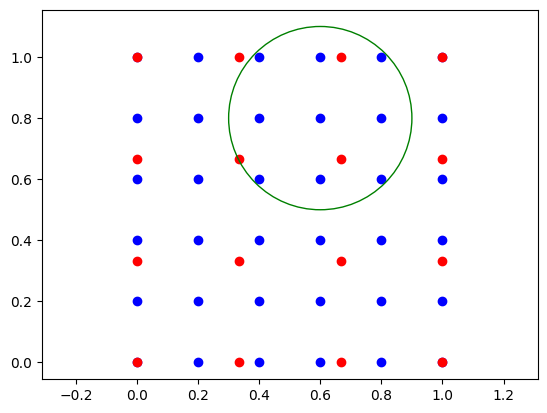

In [ ]:
index = 13

print(M[:, index])

print('Value in node:', values_fine[index])

print('Values to interpolate:', values_coarse[np.where(M[:, index] > -0.1)[0]])

w = (M[np.where(M[:, index] > -0.1)[0], index] + epsilon) ** (-1)
w = w / np.sum(w)
print('Weights: ', w)

fig, ax = plt.subplots()

plt.scatter(coords_fine[:, 0], coords_fine[:, 1], c='blue')
plt.scatter(coords_coarse[:, 0], coords_coarse[:, 1], c='red')

circle = plt.Circle((coords_fine[index, 0], coords_fine[index, 1]), r, color='green', fill=False)
ax.add_patch(circle)

# The red points (coarse) inside the circle are the neighbors of the blue point (fine) at the center of the circle

plt.axis('equal')
plt.show()